<a href="https://colab.research.google.com/github/sapritanand/Supply-Chain-Optimization-Inventory-Logistics-Analytics-/blob/main/Supply_Chain_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pulp as pl
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [5]:
# warehouse and stores
warehouses = ["W1","W2","W3"]
stores = ["S1","S2","S3","S4"]

# Defining the capacity of each warehouse
supply = {"W1":1000,"W2":1000,"W3":1000}

# Defining the Requirements of each Stores
demand = {"S1":950,"S2":900,"S3":600,"S4":500}

# Transportation Cost Per Unit (Matrix)
costs = {
    ("W1", "S1"): 2, ("W1", "S2"): 3, ("W1", "S3"): 1, ("W1", "S4"): 4,
    ("W2", "S1"): 3, ("W2", "S2"): 2, ("W2", "S3"): 5, ("W2", "S4"): 1,
    ("W3", "S1"): 4, ("W3", "S2"): 3, ("W3", "S3"): 2, ("W3", "S4"): 3
}

In [7]:
#  LP Model
model = pl.LpProblem("Supply_Chain_Optimization", pl.LpMinimize)

#  (How many units to ship from each warehouse to each store)
shipment = pl.LpVariable.dicts("Ship", [(w, s) for w in warehouses for s in stores], lowBound=0, cat="Continuous")

# Objective Function: Minimize Total Transportation Cost
model += pl.lpSum(shipment[w, s] * costs[w, s] for w in warehouses for s in stores), "Total_Transport_Cost"

#  Supply Capacity of Warehouses
for w in warehouses:
    model += pl.lpSum(shipment[w, s] for s in stores) <= supply[w], f"Supply_Constraint_{w}"

#  Demand Requirements of Stores
for s in stores:
    model += pl.lpSum(shipment[w, s] for w in warehouses) >= demand[s], f"Demand_Constraint_{s}"

model.solve()
print("Optimization Status:", pl.LpStatus[model.status])
print("Total Transportation Cost: $", pl.value(model.objective))


Optimization Status: Optimal
Total Transportation Cost: $ 5750.0


In [8]:

solution = []
for w in warehouses:
    for s in stores:
        solution.append([w, s, shipment[w, s].varValue, costs[w, s]])

df_solution = pd.DataFrame(solution, columns=["Warehouse", "Store", "Units Shipped", "Cost per Unit"])
print(df_solution)


   Warehouse Store  Units Shipped  Cost per Unit
0         W1    S1          950.0              2
1         W1    S2            0.0              3
2         W1    S3           50.0              1
3         W1    S4            0.0              4
4         W2    S1            0.0              3
5         W2    S2          500.0              2
6         W2    S3            0.0              5
7         W2    S4          500.0              1
8         W3    S1            0.0              4
9         W3    S2          400.0              3
10        W3    S3          550.0              2
11        W3    S4            0.0              3


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128666 (\N{DELIVERY TRUCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


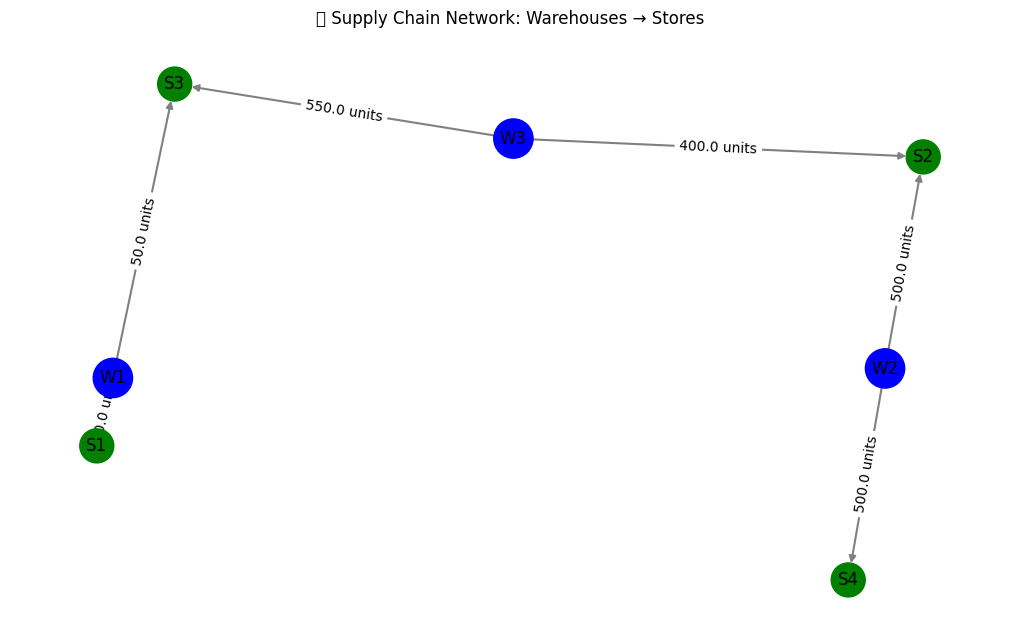

In [9]:

G = nx.DiGraph()

#  Nodes
for w in warehouses:
    G.add_node(w, color='blue', size=800)
for s in stores:
    G.add_node(s, color='green', size=600)

# Add Edges (Shipments)
edges = []
for _, row in df_solution.iterrows():
    if row["Units Shipped"] > 0:
        G.add_edge(row["Warehouse"], row["Store"], weight=row["Units Shipped"], label=f'{row["Units Shipped"]} units')

# Draw Graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
colors = [G.nodes[n]["color"] for n in G.nodes]
sizes = [G.nodes[n]["size"] for n in G.nodes]

nx.draw(G, pos, with_labels=True, node_color=colors, node_size=sizes, edge_color='gray', width=1.5)
edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("🚚 Supply Chain Network: Warehouses → Stores")
plt.show()


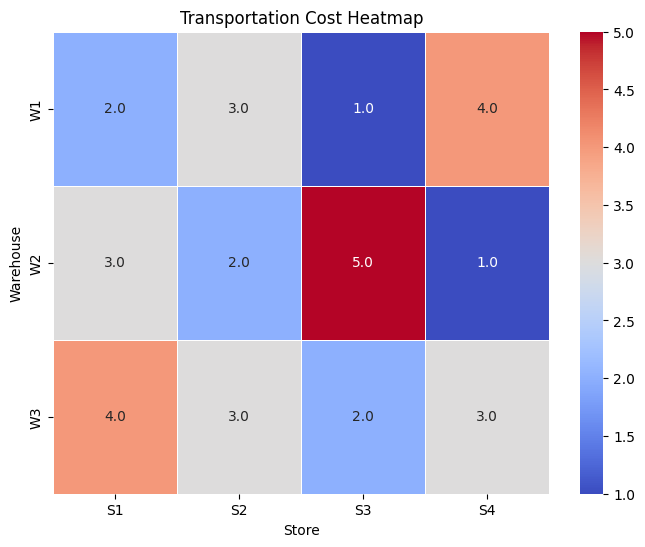

In [12]:
# data for Heatmap
cost_matrix = df_solution.pivot(index="Warehouse", columns="Store", values="Cost per Unit")

#  Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cost_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".1f")
plt.title("Transportation Cost Heatmap")
plt.show()

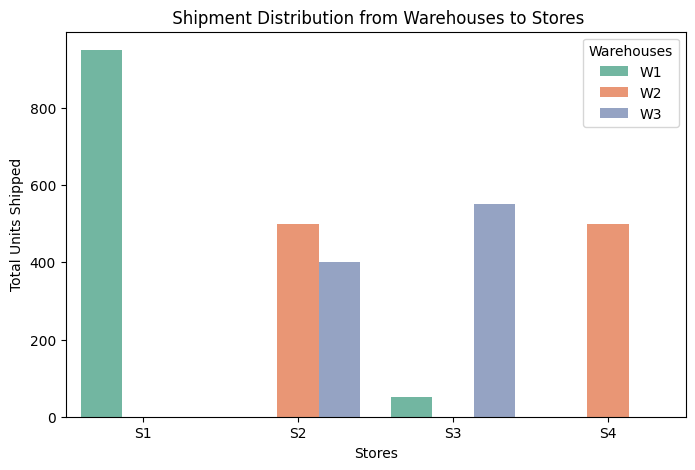

In [13]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Store", y="Units Shipped", hue="Warehouse", data=df_solution, palette="Set2")
plt.title(" Shipment Distribution from Warehouses to Stores")
plt.xlabel("Stores")
plt.ylabel("Total Units Shipped")
plt.legend(title="Warehouses")
plt.show()
